# About
This notebook shall investigate why simple odds based on a team's regular season wins & losses do not perform too well.
***

# Preface
## Imports

In [40]:
import os
os.chdir("/home/jovyan/work")

from IPython.core.display import HTML
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sqlalchemy import text

from src.plotting import plot_odds
from src.utils import calc_odds, get_connection

## Config

In [41]:
%matplotlib inline
sns.set()
HTML("""
<style>
.output_png{
text-align:center;
}
</style>
""")

***

# Get the enriched NCAA matches
First one has to fetch the real results from the ncaa tournament enriched with the number of wins & losses per team. When renaming the columns as show below it is crucial to keep in mind that **team_a is always the winning team**.

In [73]:
df_ncaa_results_wins_losses = pd.read_sql(
    sql=text("""
SELECT
ncaa.season as team_id_a,
ncaa.w_team_id,
wins_a.wins as wins_a,
losses_a.losses as losses_a,
ncaa.l_team_id as team_id_b,
wins_b.wins as wins_b,
losses_b.losses as losses_b
FROM t_original_ncaa_tourney_compact_results ncaa

-- join info about winning team
JOIN t_derived_wins_per_team_per_season wins_a
    ON ncaa.w_team_id = wins_a.team_id
    AND ncaa.season = wins_a.season
    
JOIN t_derived_losses_per_team_per_season losses_a
    ON ncaa.w_team_id = losses_a.team_id
    AND ncaa.season = losses_a.season
    
-- join info about losing team
JOIN t_derived_wins_per_team_per_season wins_b
    ON ncaa.l_team_id = wins_b.team_id
    AND ncaa.season = wins_b.season
    
JOIN t_derived_losses_per_team_per_season losses_b
    ON ncaa.l_team_id = losses_b.team_id
    AND ncaa.season = losses_b.season
    """),
    con=get_connection()
)
df_ncaa_results_wins_losses.head()

,team_id_a,w_team_id,wins_a,losses_a,team_id_b,wins_b,losses_b
0,1985,1116,21,12,1234,20,10
1,1985,1120,18,11,1345,17,8
2,1985,1207,25,2,1250,11,18
3,1985,1229,20,7,1425,19,9
4,1985,1242,23,7,1325,20,7


# Calculate the winning odds for team A
The odds are calculated based on the beta distribution and bootstrapping as shown in the notebook [0.1-jgoerner-winnig-odds-per-game.ipynb](./0.1-jgoerner-winnig-odds-per-game.ipynb)

In [74]:
df_ncaa_w_l_odds = calc_odds(df_ncaa_results_wins_losses, 1000, 100)

## Get an overall view on the team A odds
If the general odds would perfectly correlate with a win of team A, all the odds would be 1.0 (or close). As the following histogram idicicates, this is not always the case.

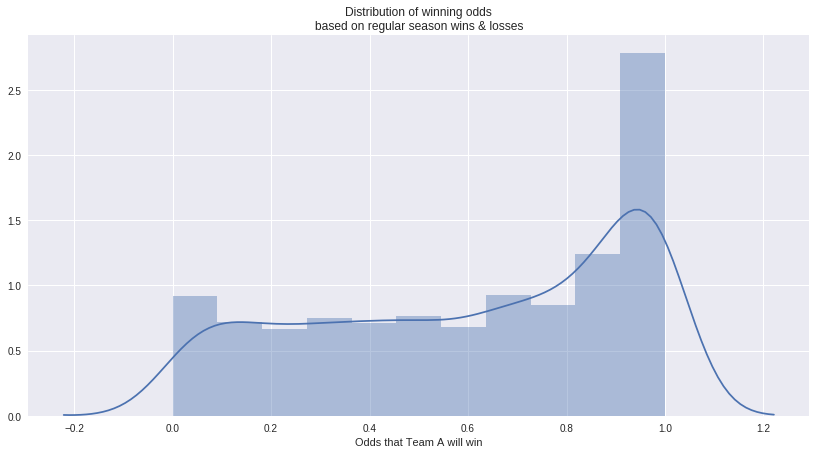

In [82]:
sns.distplot(df_ncaa_w_l_odds["odds_a"])
plt.title("Distribution of winning odds\nbased on regular season wins & losses")
plt.xlabel("Odds that Team A will win");
#plt.savefig("./figures/01_jgoerner_why_simple_odds_fail_odd_distribution.png");

# Investigate the worst predictions
The worst predictions are those who's odds are 0.0 (or close). The log-loss function will penalize these (theoretically) with infinite loss. The following 

In [76]:
# get 6 worst predictions
df_ncaa_w_l_odds.sort_values("odds_a")[:6]

,team_id_a,w_team_id,wins_a,losses_a,team_id_b,wins_b,losses_b,odds_a
1228,2004,1104,17,12,1390,29,1,0.00007
407,1991,1437,16,14,1343,23,2,0.00023
1945,2015,1301,20,13,1437,32,2,0.00025
180,1987,1261,18,14,1177,26,2,0.00028
171,1987,1261,18,14,1396,31,3,0.00032
803,1997,1112,19,9,1242,31,1,0.00045


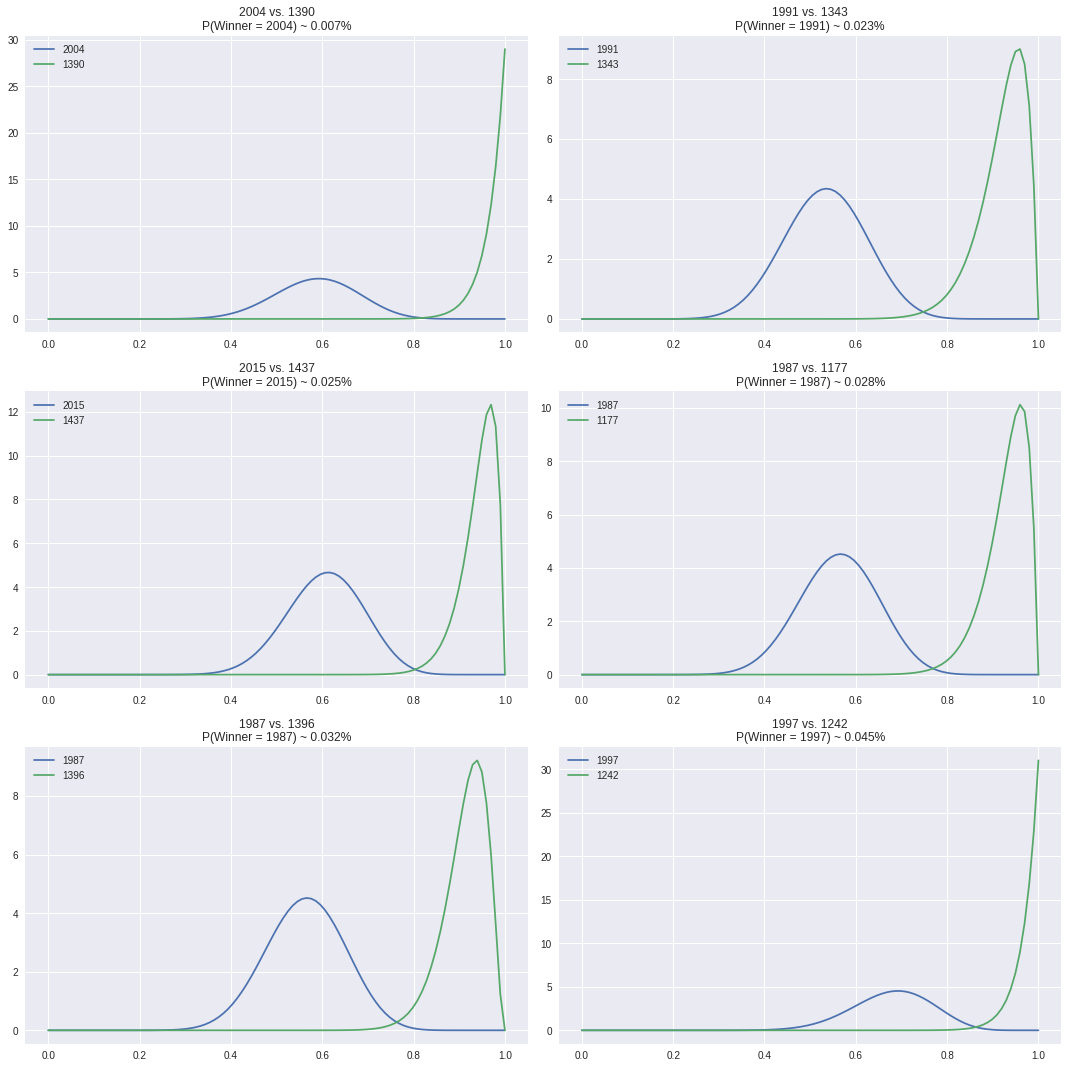

In [83]:
# plot the 6 worst predictions
plt.rcParams["figure.figsize"] = (15, 15)
fig, ax = plt.subplots(3, 2)
plt.sca(ax[0, 0])
plot_odds(df_ncaa_w_l_odds.sort_values("odds_a").iloc[0,:])
plt.sca(ax[0, 1])
plot_odds(df_ncaa_w_l_odds.sort_values("odds_a").iloc[1,:])
plt.sca(ax[1, 0])
plot_odds(df_ncaa_w_l_odds.sort_values("odds_a").iloc[2,:])
plt.sca(ax[1, 1])
plot_odds(df_ncaa_w_l_odds.sort_values("odds_a").iloc[3,:])
plt.sca(ax[2, 0])
plot_odds(df_ncaa_w_l_odds.sort_values("odds_a").iloc[4,:])
plt.sca(ax[2, 1])
plot_odds(df_ncaa_w_l_odds.sort_values("odds_a").iloc[5,:])
plt.tight_layout();
#plt.savefig("./figures/01_jgoerner_why_simple_odds_fail_worst_predictions.png");

# Outlook
As one can see the winnig team (blue) was always considered an underdoog - only taking the regular season odds into account. The following information might improve the bayesian approach:
- calculate the [odds based on historical NCAA wins & losses](./0.3-jgoerner-influence-historical-ncaa-odds.ipynb)
- weight the regular season wins (e.g. a 90:60 win is more meaningful than a 81:80 win)
- ...